## Answer the following

1. Aggregate the Sales_Qty for each Store-SKU at a month level; detect any Outliers in the Sales_Qty for each Store-SKU combination and apply an outlier treatment on the same.
Specify the outlier treatment technique.  


2. Estimate the level of promotions (Discount%) for each Category-Store level at a month level - remove any outliers / inconsistencies from this, and specify the technique used; the level of promotions is defined as $$Discount\% = (1 - sum of SP / sum of MRP)$$  


3. Estimate the inventory levels at a weekly level for each Store-SKU by interpolating missing values from data on secondary and primary sales; the following equation holds true in general: (you can do this for a shorter period of Jan 2017 to Mar 2017) 
$$Closing\ inventory\ on\ day\ [t] = Closing\ inventory\ on\ day\ [t-1] $$
$$                                - Secondary(sales - returns)\ on\ day\ [t] $$
$$                                + Primary (sales - returns)\ on\ day\ [t]$$
    NOTE:
        a. Secondary sales is the file named “WC_DS_Ex1_Sec_Sales.csv” - and it refers to sales from stores to customers (and returns by customers)
        b. Primary sales is the file name “WC_DS_Ex1_Pri_Sales.csv” - and it refers to stock movements from retailer WH to stores (and returns back to WH)
        c. Returns in both datasets are indicated by negative values in ‘Sales_Qty’ and ‘Qty’ fields respectively  


4. The inventory estimations in Question 3 will have data inconsistencies - take any assumption to resolve them and explain that assumption  


5. Using the Secondary sales data and inventory series from Question 3, determine average out-of-stock percentage (OOS%) for each Category-Store combination at a monthly level; the OOS % is defined as: 
$$ OOS\% = 1 - \{Average\ of\ no.\ of\ unique\ SKUs\ in\ stock\ each\ day / No.\ of\ unique\ SKUs\ in\ stock\ over\ the\ entire\ month\}$$ (for each Category-Store combination each month)
( Again - do this for a short period of Jan 2017 - Mar 2017; for forecasting you can
assume that the retailer will experience similar OOS levels in Jan-Mar 2018 )   


6. Using the historical secondary sales, inventory series, OOS% levels and promotion levels, determine the demand for each Store-SKU combination at a monthly level for the forecast period; use any forecasting technique that you’re comfortable with (you may use multiple techniques)  


7. Explain the approach for Question 6 clearly e.g. dividing data into train, validation and test sets, choice of technique used, metric(s) used to evaluate the results   


8. If any of the above steps is becoming computationally too expensive or taking too long; you are free to either simplify them or reduce the complexity (e.g. impute weekly inventory positions instead of daily)   

In [36]:
import warnings
import itertools, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
# import statsmodels.api as sm

from lib import datasetPrimAnalysis, namestr, splitTimeSeriesData
# warnings.filterwarnings("ignore")
# plt.style.use('fivethirtyeight')
# matplotlib.rcParams['axes.labelsize'] = 14
# matplotlib.rcParams['xtick.labelsize'] = 12
# matplotlib.rcParams['ytick.labelsize'] = 12
# matplotlib.rcParams['text.color'] = 'k'

In [2]:
## Reading Data
# df = pd.read_excel("Superstore.xls")

primDf = pd.read_csv('data/WC_DS_Ex1_Pri_Sales.csv')
secDf = pd.read_csv('data/WC_DS_Ex1_Sec_Sales.csv')
invDf = pd.read_csv('data/WC_DS_Ex1_Inv.csv')

df_li = {'Secondary': secDf, 
         'Primary':primDf, 
         'Inventory': invDf
        }


In [3]:
## transfering the feature "SKU_Code" to object and then viewing the result
for df_name in df_li:
    print('"{}" dataframe shape:  {}'.format(df_name, df_li[df_name].shape))
    
    ## Changing feature data type to object
    df_li[df_name][['SKU_Code']] = df_li[df_name][['SKU_Code']].astype(str)
    
    ## Changing feature data type to datetime
    # df_li[df_name]['Date'] = [ datetime.strptime(ele, '%Y-%m-%d') for ele in df_li[df_name]['Date'] ] # %H:%M:%S
    df_li[df_name]['Date'] = pd.to_datetime(df_li[df_name]['Date'],format='%Y-%m-%d') 
    
    ## sorting df based on Date
    df_li[df_name].sort_values(by=['Date'], inplace=True)
    df_li[df_name].reset_index(drop=True, inplace=True)
    
    display(df_li[df_name].head())
    _ = datasetPrimAnalysis(df_li[df_name])
    print('****'*25,'\n\n')

"Secondary" dataframe shape:  (24554, 7)


,Store_Code,SKU_Code,Category,Date,Sales_Qty,MRP,SP
0,Store3,603693,Cat1,2016-01-01,1,1095.0,1095.0
1,Store3,614427,Cat2,2016-01-01,1,645.0,645.0
2,Store1,610221,Cat1,2016-01-01,1,1095.0,808.7
3,Store2,600252,Cat1,2016-01-01,1,1095.0,808.7
4,Store3,600960,Cat2,2016-01-01,1,795.0,795.0


Overall dataset shape : (24554, 7)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,first,last,%Missing
Date,0,datetime64[ns],0,24554,700,2017-10-31,757,2016-01-01,2017-12-31,0.0


____________| Number of feature/s which are Qualitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
Store_Code,0,object,0,24554,3,Store3,10957,"[Store3, Store1, Store2]",0.0
SKU_Code,0,object,0,24554,2321,600852,112,"[603693, 614427, 610221, 600252, 600960, 60135...",0.0
Category,0,object,0,24554,4,Cat2,9428,"[Cat1, Cat2, Cat4, Cat3]",0.0


____________| Number of feature/s which are Quantitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
Sales_Qty,0,int64,0,24554.0,0.911827,0.416639,-1.0,1.0,1.0,1.0,2.0,0.0
MRP,0,float64,0,24554.0,894.296449,512.014141,-2195.0,745.0,945.0,1095.0,3590.0,0.0
SP,0,float64,0,24554.0,797.072665,472.947315,-2195.0,645.0,836.5,1030.2,3590.0,0.0


**************************************************************************************************** 


"Primary" dataframe shape:  (21115, 5)


,Store_Code,SKU_Code,Category,Date,Qty
0,Store1,603132,Cat1,2015-12-11,2
1,Store1,614490,Cat2,2015-12-11,1
2,Store3,603819,Cat2,2015-12-11,2
3,Store3,603810,Cat2,2015-12-11,1
4,Store3,603417,Cat3,2015-12-11,1


Overall dataset shape : (21115, 5)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,first,last,%Missing
Date,0,datetime64[ns],0,21115,66,2017-03-31,1428,2015-12-11,2017-12-25,0.0


____________| Number of feature/s which are Qualitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
Store_Code,0,object,0,21115,3,Store3,8109,"[Store1, Store3, Store2]",0.0
SKU_Code,0,object,0,21115,2463,603804,39,"[603132, 614490, 603819, 603810, 603417, 60314...",0.0
Category,0,object,0,21115,4,Cat1,10048,"[Cat1, Cat2, Cat3, Cat4]",0.0


____________| Number of feature/s which are Quantitative : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
Qty,0,int64,0,21115.0,1.048307,1.64839,-12.0,1.0,1.0,2.0,30.0,0.0


**************************************************************************************************** 


"Inventory" dataframe shape:  (58835, 5)


,Store_Code,SKU_Code,Category,Date,SOH
0,Store3,602994,Cat1,2016-06-27,1
1,Store2,600366,Cat4,2016-06-27,1
2,Store1,600366,Cat4,2016-06-27,5
3,Store3,600366,Cat4,2016-06-27,4
4,Store2,600369,Cat4,2016-06-27,1


Overall dataset shape : (58835, 5)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,first,last,%Missing
Date,0,datetime64[ns],0,58835,19,2017-08-22,3751,2016-06-27,2017-12-21,0.0


____________| Number of feature/s which are Qualitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
Store_Code,0,object,0,58835,3,Store1,21748,"[Store3, Store2, Store1]",0.0
SKU_Code,0,object,0,58835,2283,603897,113,"[602994, 600366, 600369, 600384, 600372, 60037...",0.0
Category,0,object,0,58835,4,Cat1,23015,"[Cat1, Cat4, Cat2, Cat3]",0.0


____________| Number of feature/s which are Quantitative : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
SOH,0,int64,0,58835.0,1.951355,1.227142,1.0,1.0,2.0,2.0,15.0,0.0


**************************************************************************************************** 




In [4]:
## splitting the dataset

split_date = pd.datetime(2017, 6, 1)
for df_name in df_li:
    '''    x='qwe'; x1= 'asd';  exec("%s = %d; %s = %d" % (x,2,x1,3)); print(qwe, asd)
    '''
    print(df_name)
    varName = namestr(df_li[df_name], globals())[0]
    exec("{0}, {1} = splitTimeSeriesData(df_li[df_name], split_date)".format(varName+'_train', varName+'_test'))

print('\nOriginal "Primary" DataFrame Shape: {} \n\tTrain Shape: {}\tTest Shape:{}'.format(
    primDf.shape, primDf_train.shape, primDf_test.shape))

Secondary
Original DataFrame Shape: (24554, 7) 
	Train Shape: (17225, 7)	Test Shape:(7329, 7)
Primary
Original DataFrame Shape: (21115, 5) 
	Train Shape: (14679, 5)	Test Shape:(6436, 5)
Inventory
Original DataFrame Shape: (58835, 5) 
	Train Shape: (35700, 5)	Test Shape:(23135, 5)

Original "Primary" DataFrame Shape: (21115, 5) 
	Train Shape: (14679, 5)	Test Shape:(6436, 5)


In [5]:
## Analyzing Primary DataSet: Stores Sales

'''
Aggregate the Sales_Qty for each Store-SKU at a month level; detect any Outliers in the Sales_Qty 
for each Store-SKU combination and apply an outlier treatment on the same. Specify the outlier 
treatment technique.
'''

temp_DF = primDf.copy()

# primDf.agg({'A' : ['sum', 'min'], 'B' : ['min', 'max']})

## Answering Some primary Question

Analyzing the number of unique product present in each store.


,Store_Code,Category,SKU_Code,unique_SKU_Cnt
0,Store1,Cat1,"[603132, 601431, 603141, 603147, 603729, 60373...",1028
1,Store1,Cat2,"[614490, 609357, 609378, 603819, 603804, 61447...",586
2,Store1,Cat3,"[603405, 603429, 603435, 603432, 610053, 61001...",145
3,Store1,Cat4,"[602055, 602793, 608640, 602727, 609864, 60257...",477
4,Store2,Cat1,"[600003, 601434, 616017, 616107, 603150, 60314...",948
5,Store2,Cat2,"[603819, 614496, 614487, 609987, 614478, 61452...",569
6,Store2,Cat3,"[610017, 604368, 604314, 604341, 604323, 60433...",132
7,Store2,Cat4,"[609864, 608616, 608640, 618984, 618981, 61897...",425
8,Store3,Cat1,"[603147, 601431, 616158, 616077, 616074, 60878...",1102
9,Store3,Cat2,"[603819, 603810, 614526, 614442, 609978, 60380...",611


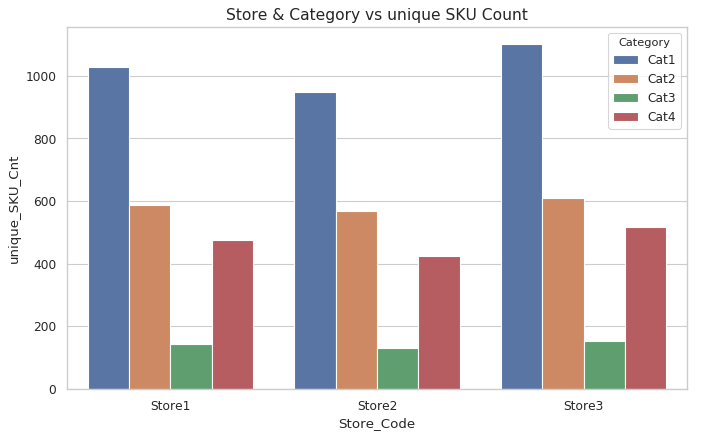

In [6]:
## Are all category present in all stores
print('Analyzing the number of unique product present in each store.')
tempDF = pd.DataFrame(temp_DF.groupby(by= ['Store_Code', 'Category'])['SKU_Code'].unique().sort_index())
tempDF.reset_index(inplace=True)
tempDF['unique_SKU_Cnt'] = tempDF['SKU_Code'].apply(lambda x: len(x))
# tempDF.rename(columns={'Category': 'NoOfUniqueSKU'}, inplace=True)
# A.index.levels[0], A.index.levels[1], A['Store1']['Cat1']
display(tempDF)
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
sns.set(style="whitegrid")
sns.barplot(x= 'Store_Code', y= 'unique_SKU_Cnt', hue='Category', data= tempDF)
plt.title('Store & Category vs unique SKU Count', fontsize=14)
plt.show()

#### Discussion
Averge number of unique products :  $Store3$ > $Store1$ > $Store2$  

Averge number of unique products :  $Cat1$ > $Cat2$ > $Cat4$ > $Cat3$

In [10]:
## Are unique product sold through
print('Analyzing Are unique product sold through.')

tempDF = pd.DataFrame(temp_DF.groupby(by= ['Store_Code', 'Date', 'Category'])['SKU_Code'].unique().sort_index())
tempDF.reset_index(inplace=True)
tempDF['unique_SKU_Cnt'] = tempDF['SKU_Code'].apply(lambda x: len(x))
# tempDF.rename(columns={'Category': 'NoOfUniqueSKU'}, inplace=True)
# A.index.levels[0], A.index.levels[1], A['Store1']['Cat1']

tempDF.set_index('Date', inplace=True)
display(tempDF.head(15))

Analyzing Are unique product sold through.


,Store_Code,Category,SKU_Code,unique_SKU_Cnt
Date,,,,
2015-12-11,Store1,Cat1,"[603132, 601431, 603141, 603147, 603729, 60373...",29
2015-12-11,Store1,Cat2,"[614490, 609357, 609378, 603819, 603804, 61447...",17
2015-12-11,Store1,Cat3,"[603405, 603429, 603435, 603432, 610053, 61001...",7
2015-12-11,Store1,Cat4,"[602055, 602793, 608640, 602727, 609864, 60257...",9
2015-12-17,Store1,Cat1,"[610272, 609405, 610293, 601458, 601428, 60135...",74
2015-12-17,Store1,Cat2,"[609363, 609375, 609378, 609351, 601131, 60385...",30
2015-12-17,Store1,Cat3,"[604326, 604314, 604368, 604329, 604335, 60436...",12
2015-12-29,Store1,Cat1,"[602961, 601536, 603534, 610257, 603546, 60921...",61
2015-12-29,Store1,Cat2,"[609354, 610410, 609375, 606078, 610374, 61039...",10


2015
Store1


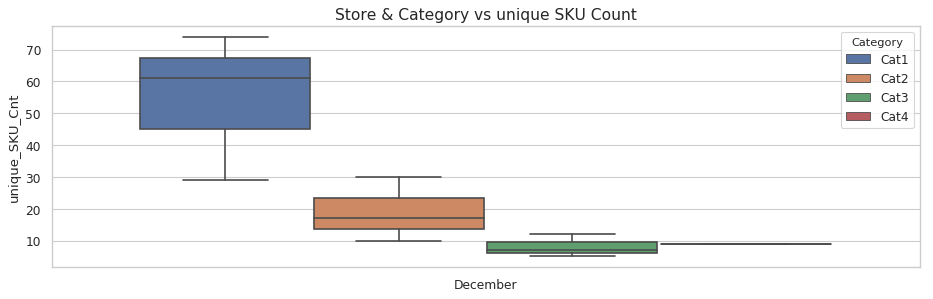

Store2


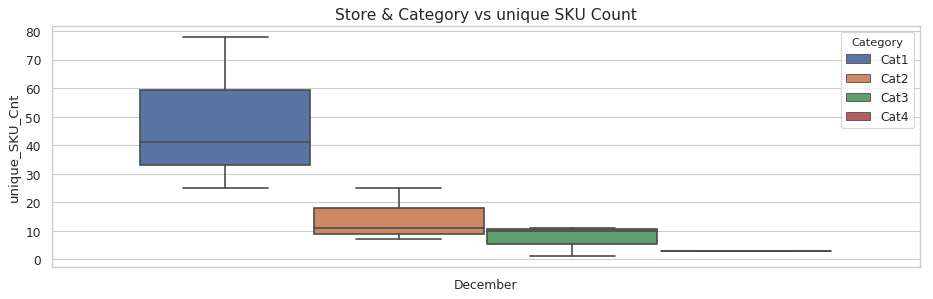

Store3


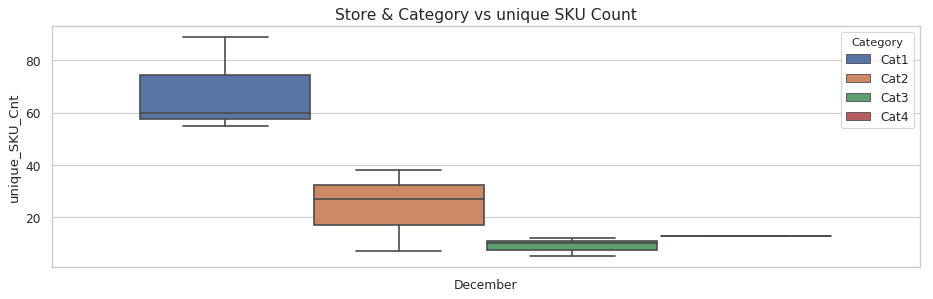

2016
Store1


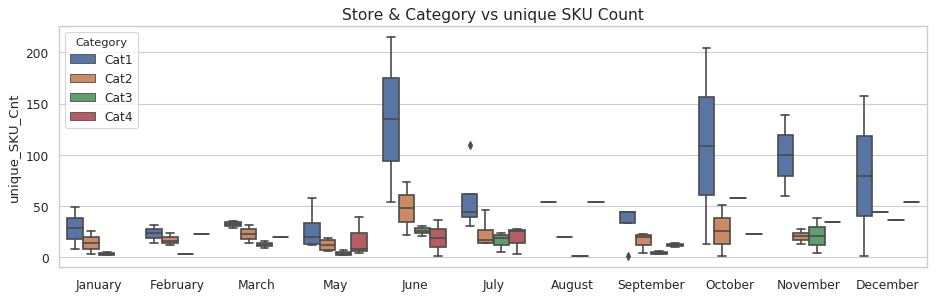

Store2


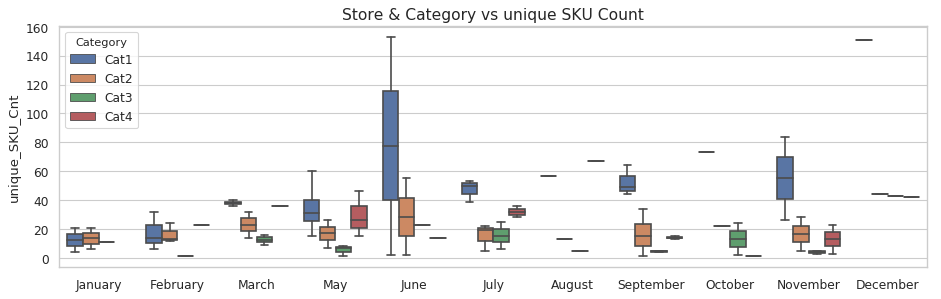

Store3


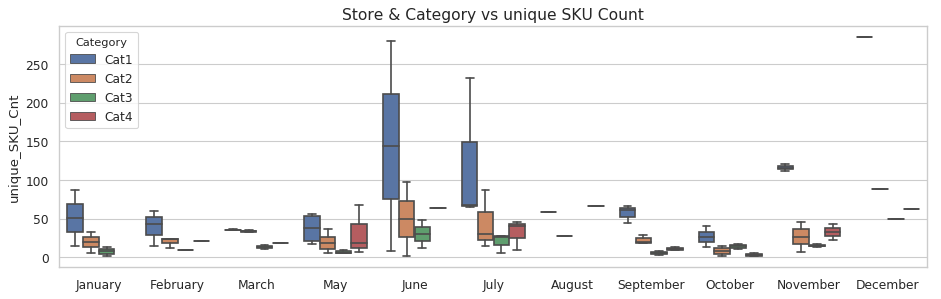

2017
Store1


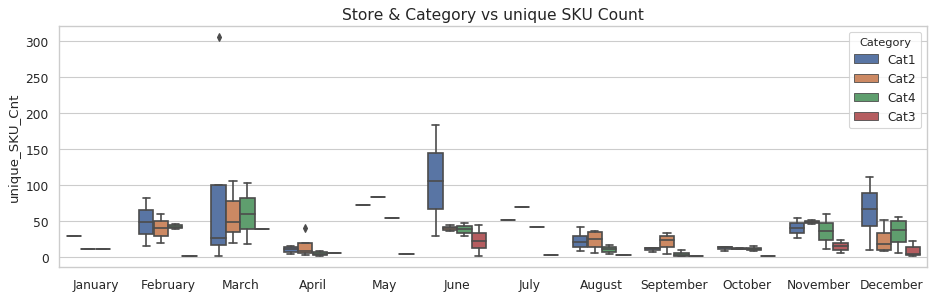

Store2


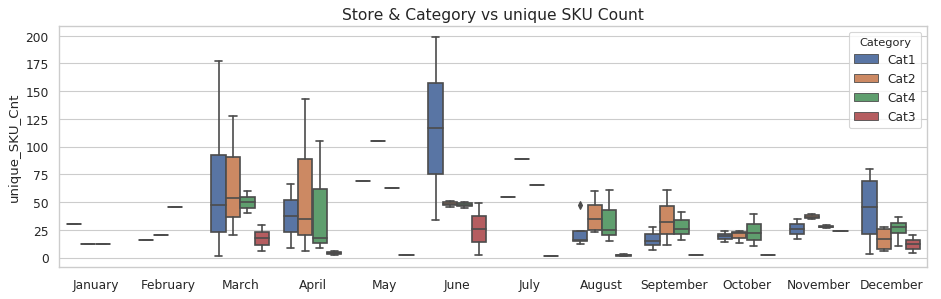

Store3


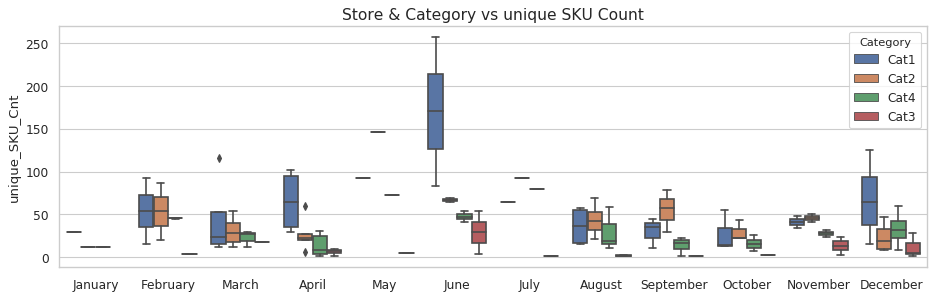

In [11]:
# 
for yr in range(min(tempDF.index).year, max(tempDF.index).year+1):
    print(yr)
    t = tempDF.loc[tempDF.index.year == yr,:]
    
    for sto in tempDF['Store_Code'].unique():
        print(sto)
        ts = t.loc[t['Store_Code']== sto, :]#.reset_index()
        mon = [ ele.month_name() for ele in ts.index ]
#         display(ts)
        plt.figure(num=None, figsize=(14, 4), dpi=80, facecolor='w', edgecolor='k')
        sns.set(style="whitegrid")
        ax = sns.boxplot(x= mon, y= 'unique_SKU_Cnt', hue='Category', data= ts)
        # ax = sns.swarmplot(x= mon, y= 'unique_SKU_Cnt', hue='Category', data= ts, color=".25")
#         sns.catplot(x= mon, y= 'unique_SKU_Cnt', hue='Category', col='Store_Code', data= ts, kind="box",
#                    #x="sex", y="total_bill", hue="smoker", col="time", data=tips, kind="box",
#                    height=4, aspect=.7)
        plt.title('Store & Category vs unique SKU Count', fontsize=14)
        plt.show()

In [9]:
# Checking is time series is having uniform TimeDifference 

# display(temp_DF)



## Answering Question Number 3

In [139]:
temp_sDF, temp_pDF = secDf.copy(), primDf.copy()
temp_pDF = pd.DataFrame(temp_pDF.groupby(by= ['Store_Code', 'SKU_Code', 'Date'])['Qty'].sum().sort_index())#.reset_index()
temp_sDF = pd.DataFrame(temp_sDF.groupby(by= ['Store_Code', 'SKU_Code', 'Date'])['Sales_Qty'].sum().sort_index())#.reset_index()
# display(temp_pDF.head())
# display(temp_sDF.head())

totQua = temp_sDF.join(temp_pDF, how='outer').reset_index().fillna(0)
print('DataFrame Shape', totQua.shape)

## Working with Smalller Data which liess between Jan2017 and Mar 2017
totQua = totQua.loc[(totQua['Date'] >= '2017-01-01') & (totQua['Date'] <= '2017-03-31'), :]
totQua.reset_index(drop=True, inplace=True)

print('New DataFrame Shape', totQua.shape)
display(totQua.head())

DataFrame Shape (43290, 5)
New DataFrame Shape (5001, 5)


,Store_Code,SKU_Code,Date,Sales_Qty,Qty
0,Store1,600012,2017-02-15,0.0,1.0
1,Store1,600015,2017-02-15,0.0,1.0
2,Store1,600024,2017-01-18,1.0,0.0
3,Store1,600024,2017-02-15,0.0,1.0
4,Store1,600045,2017-02-15,0.0,1.0


In [140]:
## Determioning the adequate initial value
totQua['QtyCn'] = totQua['Qty'].subtract(totQua['Sales_Qty'])
adQn = totQua.groupby(by=['Store_Code', 'SKU_Code', 'Date'])['QtyCn'].sum()
adQn = adQn.groupby(['Store_Code', 'SKU_Code']).cumsum() ## Cumulation over 'Storecode' & Sku
adQn = adQn.groupby(['Store_Code', 'SKU_Code']).min()

totQua.drop(columns=['QtyCn'], inplace=True)

In [142]:
## Adding Closing Inventory 
totQua['ClosingInvOfDay'] = 0

Question: Number of Inventory we sshould have at the begining

DailyFluctuation = [1, -1, -4, -2, 5, 3] 

So if we start with x at the begening then the total stored inventory will fluctuate like
[x+1, x, x-4, x-6, x+1, x+4]

if x= 0 then we can say that this is   
CumulativeFluctuation = [1, 0, -4, -6, 1, 4]
So the mininmum vallue that x will have soo that the stored quantity is always >=0 is x=6 in the emaple  above



In [ ]:
adQn[st][prod]

In [37]:
## Computing the overall Quantity -- Starting Qunatity is Computed such that qunatity was always available
tSt = int(time.time())
for st in totQua['Store_Code'].unique():
    for prod in totQua.loc[totQua['Store_Code']==st,'SKU_Code'].unique():
        t = totQua.loc[(totQua['Store_Code']==st) & (totQua['SKU_Code']==prod), \
                       ['Date', 'Sales_Qty', 'Qty', 'ClosingInvOfDay']].reset_index(drop=True)
        for i in t.index:
            if i==0:
                quantitytoStartWith = sum(t['Qty'])*-1 + sum(t['Sales_Qty'])  ## Approximation: will result in zero at the end
                quantInStore = quantitytoStartWith
            quantInStore = quantInStore - t['Sales_Qty'][i] + t['Qty'][i]
            totQua.loc[(totQua['Store_Code']==st) & (totQua['SKU_Code']==prod) & \
                       (totQua['Date'] == t['Date'][i]), 'ClosingInvOfDay'] = quantInStore
print('Total Time Taken to compute  this {} sec'.format(int(time.time())-tSt))

Total Time Taken to compute  this 157 sec


In [39]:
totQua

,Store_Code,SKU_Code,Date,Sales_Qty,Qty,ClosingInvOfDay
0,Store1,600012,2017-02-15,0.0,1.0,0.0
1,Store1,600015,2017-02-15,0.0,1.0,0.0
2,Store1,600024,2017-01-18,1.0,0.0,-1.0
3,Store1,600024,2017-02-15,0.0,1.0,0.0
4,Store1,600045,2017-02-15,0.0,1.0,1.0
5,Store1,600045,2017-03-25,1.0,0.0,0.0
6,Store1,600051,2017-02-15,0.0,1.0,1.0
7,Store1,600051,2017-03-04,1.0,0.0,0.0
8,Store1,600054,2017-03-18,1.0,0.0,0.0
9,Store1,600057,2017-01-15,1.0,0.0,-1.0


In [20]:
A = totQua['Date']
A.dt.week


0         6
1        12
2        22
3        26
4        27
5         2
6         7
7        30
8        30
9        33
10       20
11       24
12       45
13       47
14       52
15       14
16        7
17        9
18       12
19       15
20       20
21       36
22       39
23        7
24       14
25       14
26       16
27       18
28       19
29       22
         ..
43260    45
43261    45
43262    45
43263    51
43264    45
43265    45
43266    45
43267    45
43268    45
43269    45
43270    45
43271    45
43272    45
43273    45
43274    45
43275    45
43276    45
43277    45
43278    45
43279    45
43280    45
43281    45
43282    45
43283    45
43284    52
43285    52
43286    52
43287    52
43288    52
43289    52
Name: Date, Length: 43290, dtype: int64

In [ ]:
## is Time Difference between series uniform and if it is, then what is the time difference

In [ ]:
a= tempDF['Date'][1]
a.strftime(format= '%Y-%m')

tempDF['YYMM'] = tempDF['Date'].apply(lambda x: x.strftime(format= '%Y-%m'))



# tempDF.agg({'YYMM' : ['sum', 'min'], 'Qty' : ['min', 'max', 'sum']})

# tempDF.apply(np.min, axis=0)

gk = tempDF.groupby(by = ['YYMM', 'Store_Code', 'SKU_Code'], axis=0)
gk.first()
gk.Qty.agg(np.sum)

gk = tempDF.groupby(by = ['YYMM', 'Store_Code'], axis=0)
gk.first()
gk.Qty.agg(np.sum)

In [ ]:
tempDF.iloc[0,:]['Date']

In [ ]:
a=secDf[secDf["SKU_Code"].str.contains("603132")] # -1 signifies stock empty

In [ ]:
a.loc[a['Sales_Qty'] == -1,: ]

In [ ]:
primDf_train.set_index('Date', inplace=True)
display(primDf_train.head())

In [ ]:
ts = primDf_train['Qty']

In [ ]:
## Dickey Fuller Test: This is one of the statistical tests for checking stationarity.

from statsmodels.tsa.stattools import adfuller
ts = primDf_train['Qty']

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    # rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(ts)